In [2]:
import os
import flexynesis
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import random
import lightning as pl
import matplotlib.pyplot as plt

torch.set_num_threads(16)
os.environ["OMP_NUM_THREADS"] = "16"

[rank: 0] Seed set to 42


# Finding Survival Markers in Lower Grade Glioma (LGG) and Glioblastoma Multiforme (GBM)seed

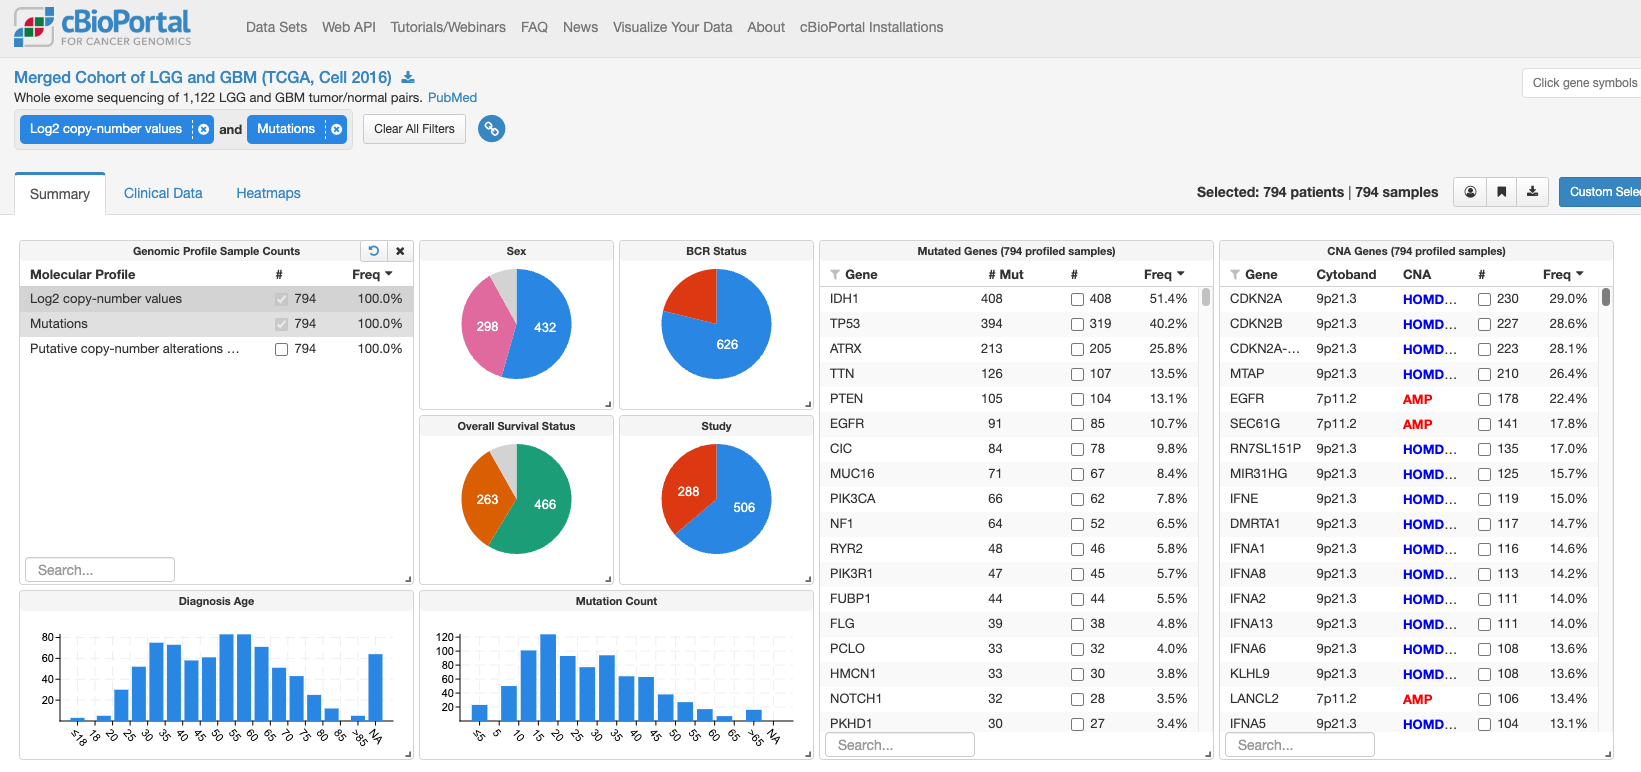

Here, we demonstrate the capabilities of `flexynesis` on a multi-omic dataset of 506 Brain Lower Grade Glioma (LGG) and 288 Glioblastoma Multiforme (GBM) samples with matching mutation and copy number alteration data downloaded from the [cbioportal](https://www.cbioportal.org/study/summary?id=lgggbm_tcga_pub). The data was split into `train` (70% of the samples) and `test` (30% of the samples) data folders. The data files were processed to follow the same nomenclature. 

- `cna.csv` contains "copy number alteration" data
- `mut.csv` contains "mutation" data, which is a binary matrix of genes versus samples. 
- `clin.csv` contains "clinical/sample metatada", which is a table of clinical parameters such as age, sex, disease type, histological diagnosis, and overall survival time and status. 

## Data Download

The data can be downloaded as follows:

In [3]:
if not os.path.exists("lgggbm_tcga_pub_processed"):
    !wget -O lgggbm_tcga_pub_processed.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/lgggbm_tcga_pub_processed.tgz" && tar -xzvf lgggbm_tcga_pub_processed.tgz

## Importing Train and Test Datasets

We import train and test datasets including mutations and copy number alterations. We rank genes by Laplacian Scores and pick top 10% of the genes, while removing highly redundant genes with a correlation score threshold of 0.8 and a variance threshold of 50%. By setting `concatenate` to `False`, we will be doing an `intermediate` fusion of omic layers. 

In [4]:
data_importer = flexynesis.DataImporter(path ='lgggbm_tcga_pub_processed', 
                                        data_types = ['mut', 'cna'], log_transform=False, 
                                        concatenate=False, top_percentile=10, min_features=1000, correlation_threshold=0.8, 
                                       variance_threshold=0.5)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing lgggbm_tcga_pub_processed/train/mut.csv...
[INFO] Importing lgggbm_tcga_pub_processed/train/cna.csv...
[INFO] Importing lgggbm_tcga_pub_processed/train/clin.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing lgggbm_tcga_pub_processed/test/mut.csv...
[INFO] Importing lgggbm_tcga_pub_processed/test/cna.csv...
[INFO] Importing lgggbm_tcga_pub_processed/test/clin.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  mut
[INFO] Number of NA values:  0
[INFO] DataFrame mut - Removed 5561 features.

[INFO] working on layer:  cna
[INFO] Number of

Filtering redundant features: 100%|██████████| 1000/1000 [00:00<00:00, 12761.06it/s]


[INFO] Implementing feature selection using laplacian score for layer: cna with  12371 features  and  556  samples 


Filtering redundant features: 100%|██████████| 1237/1237 [00:00<00:00, 207716.95it/s]



[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  mut
[INFO] Number of NA values:  0
[INFO] DataFrame mut - Removed 5627 features.

[INFO] working on layer:  cna
[INFO] Number of NA values:  0
[INFO] DataFrame cna - Removed 12382 features.
[INFO] DataFrame mut - Removed 0 samples (0.00%).
[INFO] DataFrame cna - Removed 0 samples (0.00%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: mut': 312, 'feature_count in: cna': 1237, 'sample_count': 556}
[INFO] Test Data Stats:  {'feature_count in: mut': 312, 'feature_count in: cna': 1237, 'sample_count': 238}
[INFO] Merging Feature Logs...
[INFO] Data import successful.


## 1. Exploratory Data Analysis 

Before building any machine learning models on the data, it is important to first familiarize yourself with the data you are working with. 
It is important to know the available data matrices, their sizes/shapes, available clinical variables and how they are distributed. 

Below you are asked to do simple explorations of the available data. 

## 1.1 Print the shapes of the available data matrices 

- How many features and samples are available per data type in train/test datasets? 

In [5]:
train_dataset.dat

{'mut': tensor([[-0.1485,  0.9822, -0.1721,  ..., -0.0424, -0.0424, -0.0424],
         [-0.1485,  0.9822, -0.1721,  ..., -0.0424, -0.0424, -0.0424],
         [-0.1485,  0.9822, -0.1721,  ..., -0.0424, -0.0424, -0.0424],
         ...,
         [-0.1485,  0.9822, -0.1721,  ..., -0.0424, -0.0424, -0.0424],
         [-0.1485,  0.9822, -0.1721,  ..., -0.0424, -0.0424, -0.0424],
         [-0.1485,  0.9822, -0.1721,  ..., -0.0424, -0.0424, -0.0424]]),
 'cna': tensor([[-0.2357, -0.7331, -0.8557,  ...,  0.3800, -0.8773, -0.8773],
         [-0.2305,  0.8470,  0.8485,  ...,  0.3883,  0.7991,  0.7991],
         [-0.2541, -0.7226,  0.0780,  ...,  0.4102,  0.0411,  0.0411],
         ...,
         [ 0.1852, -0.7437, -0.8670,  ...,  0.1220, -0.8885, -0.8885],
         [-0.0437, -0.7479,  0.2978,  ...,  0.4267,  0.2574,  0.2574],
         [ 7.5459,  0.6915,  0.6808,  ...,  0.4020,  0.6341,  0.6341]])}

In [6]:
train_dataset.dat['cna'].shape, train_dataset.dat['mut'].shape

(torch.Size([556, 1237]), torch.Size([556, 312]))

In [7]:
test_dataset.dat['cna'].shape, test_dataset.dat['mut'].shape

(torch.Size([238, 1237]), torch.Size([238, 312]))

## 1.2 Explore sample annotations 

- What are the available clinical variables? Are they available in both train and test datasets? (See <dataset>.ann)  

In [8]:
train_dataset.ann.keys()

dict_keys(['AGE', 'OS_MONTHS', 'OS_STATUS', 'KARNOFSKY_PERFORMANCE_SCORE', 'STUDY', 'BCR_STATUS', 'HISTOLOGICAL_DIAGNOSIS', 'SEX'])

In [9]:
test_dataset.ann.keys()

dict_keys(['AGE', 'OS_MONTHS', 'OS_STATUS', 'KARNOFSKY_PERFORMANCE_SCORE', 'STUDY', 'BCR_STATUS', 'HISTOLOGICAL_DIAGNOSIS', 'SEX'])

- Make a histogram plot of the follow up times in months (OS_MONTHS) (use sns.histplot)

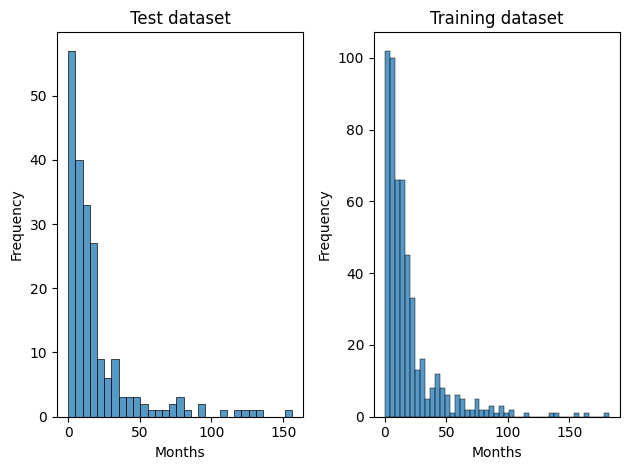

In [10]:
plt.subplot(1, 2, 1)
test_figure=sns.histplot(test_dataset.ann["OS_MONTHS"])
test_figure.set(xlabel='Months', ylabel='Frequency',title="Test dataset")
plt.subplot(1, 2, 2)
train_figure=sns.histplot(train_dataset.ann["OS_MONTHS"])
train_figure.set(xlabel='Months', ylabel='Frequency',title="Training dataset")
plt.tight_layout()

- Make a histogram of the age distribution of the patients in the training data; facet the histogram by "SEX" variable (see flexynesis.utils.plot_boxplot)

/usr/local/lib/python3.11/site-packages/flexynesis/utils.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



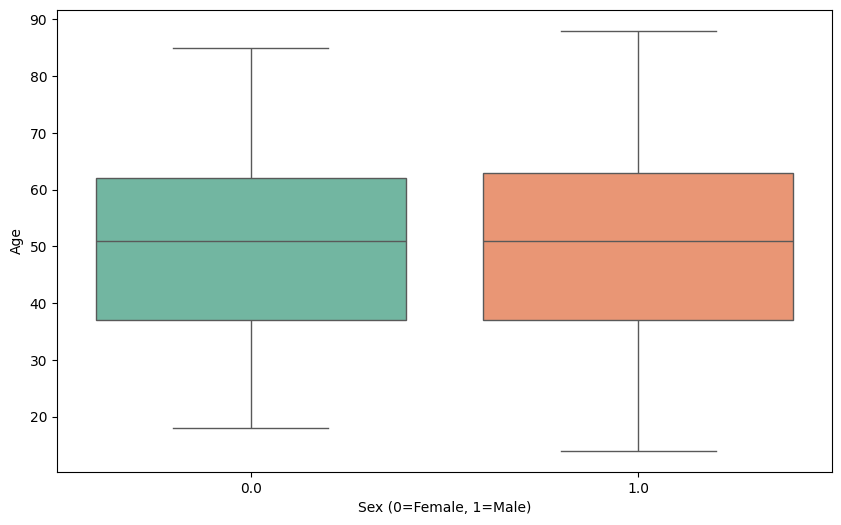

In [11]:
flexynesis.utils.plot_boxplot(train_dataset.ann["SEX"],train_dataset.ann["AGE"], title_x="Sex (0=Female, 1=Male)", title_y="Age")

- Make a summary of all available clinical variables (see flexynesis.print_summary_stats)

In [12]:
flexynesis.print_summary_stats(test_dataset)

Summary for variable: AGE
Numerical Variable Summary: Median = 52.0, Mean = 49.88516746411483
------
Summary for variable: OS_MONTHS
Numerical Variable Summary: Median = 10.9, Mean = 19.508133971291866
------
Summary for variable: OS_STATUS
Numerical Variable Summary: Median = 0.0, Mean = 0.3588516746411483
------
Summary for variable: KARNOFSKY_PERFORMANCE_SCORE
Numerical Variable Summary: Median = 90.0, Mean = 83.46456692913385
------
Summary for variable: STUDY
Categorical Variable Summary:
  Label: Brain Lower Grade Glioma, Count: 153
  Label: Glioblastoma multiforme, Count: 85
------
Summary for variable: BCR_STATUS
Categorical Variable Summary:
  Label: IGC, Count: 172
  Label: NCH, Count: 66
------
Summary for variable: HISTOLOGICAL_DIAGNOSIS
Categorical Variable Summary:
  Label: astrocytoma, Count: 52
  Label: glioblastoma, Count: 81
  Label: oligoastrocytoma, Count: 33
  Label: oligodendroglioma, Count: 43
  Label: nan, Count: 29
------
Summary for variable: SEX
Categorical V

- Notice that the categorical variables such as "SEX", "STUDY", "HISTOLOGICAL_DIAGNOSIS" are encoded numerically in the "dataset.ann" objects. Use dataset.label_mappings to map the STUDY variable to their original labels. 
Print the top 10 values in dataset.ann['STUDY'] and the mapped label values. 

In [13]:
[test_dataset.label_mappings["STUDY"][x] for x in test_dataset.ann["STUDY"].numpy()[0:10]]

['Glioblastoma multiforme',
 'Brain Lower Grade Glioma',
 'Brain Lower Grade Glioma',
 'Glioblastoma multiforme',
 'Glioblastoma multiforme',
 'Brain Lower Grade Glioma',
 'Brain Lower Grade Glioma',
 'Glioblastoma multiforme',
 'Brain Lower Grade Glioma',
 'Brain Lower Grade Glioma']

- Now, let's explore the data matrices. Make a PCA plot of the mutation data matrix and color the samples by "HISTOLOGICAL_DIAGNOSIS". See flexynesis.plot_dim_reduced function

First create a pandas data frame with the data matrix of interest with feature and sample names 
> df = pd.DataFrame(train_dataset.dat['cna'], index = train_dataset.samples, columns= train_dataset.features['cna'])

Check the data frame contents 
> df.head()

Make a PCA plot of CNA values using the labels from the STUDY variable 

**Note**: if you couldn't map the labels above, you can also use train_dataset.dat['STUDY'] as labels  

In [14]:
df = pd.DataFrame(train_dataset.dat['cna'], index = train_dataset.samples, columns= train_dataset.features['cna'])

In [23]:
df.head()

,PCA1,PCA2
0,-10.325238,19.345707
1,21.352530,-7.064666
2,-1.528412,11.796757
3,11.188336,2.342751
4,-41.128956,-18.912319
...,...,...
551,-38.310131,-21.131403
552,-36.344170,-11.035309
553,-14.437261,15.202934
554,4.888980,6.820131


In [25]:
labels = [train_dataset.label_mappings["STUDY"][x] for x in train_dataset.ann["STUDY"].numpy()]

556

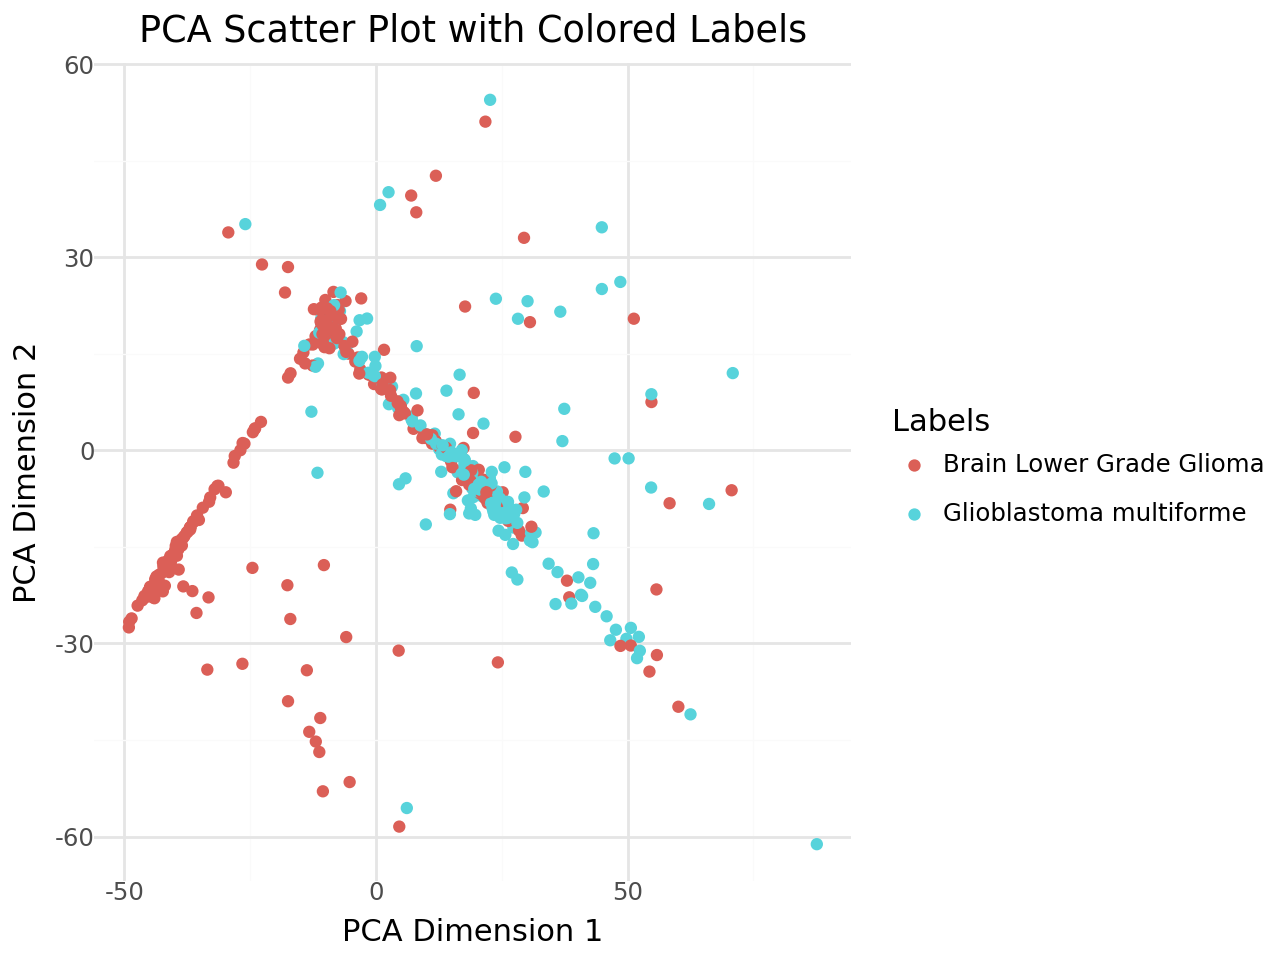

In [16]:
flexynesis.plot_dim_reduced(df, labels, color_type = 'categorical', method='pca')

- (Optional exercise ideas): 
    - Make a PCA plot coloring the samples by HISTOLOGICAL_DIAGNOSIS, GENDER, or any other clinical variable 
    - Repeat the same exercise on the mutation data matrix. 

## 2. Training a single model using manually set hyperparameters 

Now that we have familiarized ourselves with the dataset at hand, we can start building models. 

First we will do a single model training by manually setting hyperparameters. Based on the model performance, we will try modifying individual hyperparameters and build more and more models and see if we can improve model performance. 

We will need to define the following components for starting a model training:

    1. Split the train_dataset into train/validation components 
    2. Define data loaders for both train and validation splits 
    3. Define a pytorch-lightning trainer 
    4. Define a model with hyperparameters 
    5. Fit the model 

In [17]:
# randomly assign 80% of samples for training, 20% for validation 
train_indices = random.sample(range(0, len(train_dataset)), int(len(train_dataset) * 0.8))
val_indices = list(set(range(len(train_dataset))) - set(train_indices))
train_subset = train_dataset.subset(train_indices)
val_subset = train_dataset.subset(val_indices)

# define data loaders for train/validation splits 
from torch.utils.data import DataLoader
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True) 
val_loader = DataLoader(val_subset, batch_size=32, shuffle = False) 

Now, we need to define a model with manually set hyperparameters and a lightning-trainer fit the model. 

**Notice**: Notice the callback we are passing to the trainer which enables us to plot the loss values as the training progresses. 

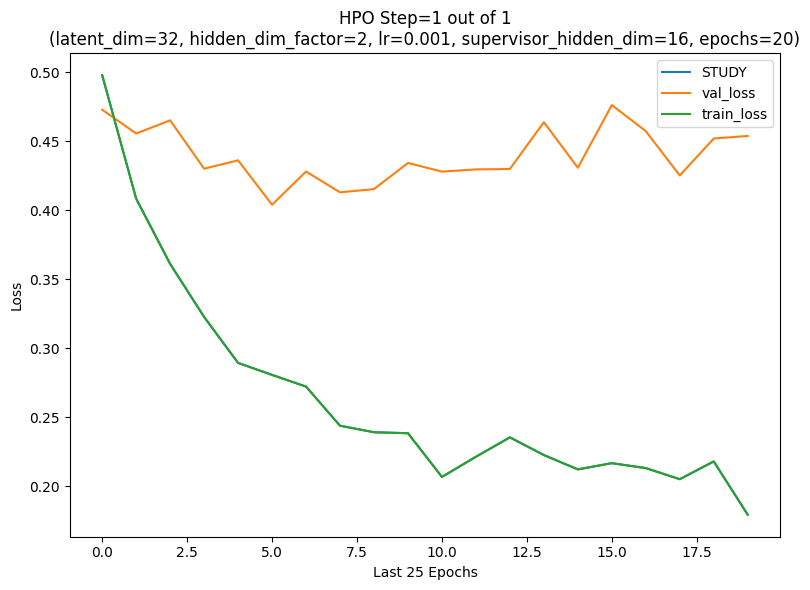

`Trainer.fit` stopped: `max_epochs=20` reached.


In [18]:
# Define a model with manually set hyperparameters for the DirectPred model 
myparams = {'latent_dim': 32, 'hidden_dim_factor': 2, 'lr': 0.001, 'supervisor_hidden_dim': 16, 'epochs': 20}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])
# Fit the model 
trainer.fit(model, train_loader, val_loader)

While we can observe how well the model training went based on the "loss" values, we can also evaluate the model performance on test dataset 

In [19]:
# evaluate the model performance on predicting the target variable
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.801961
1,DirectPred,STUDY,categorical,f1_score,0.819087
2,DirectPred,STUDY,categorical,kappa,0.605505
3,DirectPred,STUDY,categorical,average_auroc,0.871819
4,DirectPred,STUDY,categorical,average_aupr,0.772257


## 2.1 Exercise

- Now, repeat the above model training and evaluation by manually changing the hyperparameters (Try at least 5 different combinations)
- See if you can find a better hyperparameter combination that yields a better classification performance than the initial setup we provided. 
- See the default hyperparameter ranges we use for Flexynesis here: https://github.com/BIMSBbioinfo/flexynesis/blob/69b92ca9370551e9fcc82a756cb42c72bef4a4b1/flexynesis/config.py#L7, but feel free to try outside these ranges too. 
- Also try to observe the impact of the changing parameters on how the train/validation loss curves change. 

    myparams = {'latent_dim': XX, 'hidden_dim_factor': XX, 'lr': XX, 'supervisor_hidden_dim': XX, 'epochs': XX}

    model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   

    trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                         callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])

    trainer.fit(model, train_loader, val_loader)
    
    flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

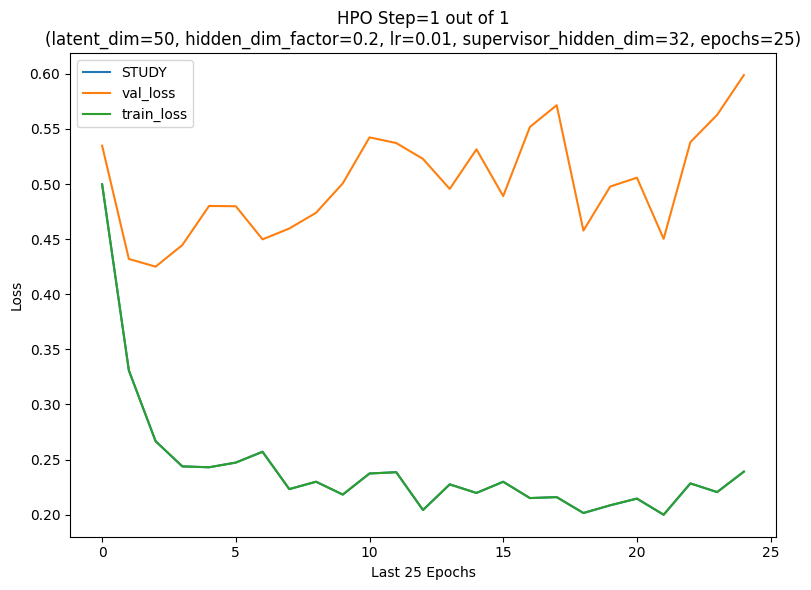

`Trainer.fit` stopped: `max_epochs=25` reached.


,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.737908
1,DirectPred,STUDY,categorical,f1_score,0.771739
2,DirectPred,STUDY,categorical,kappa,0.495238
3,DirectPred,STUDY,categorical,average_auroc,0.839369
4,DirectPred,STUDY,categorical,average_aupr,0.697824


In [20]:
myparams = {'latent_dim': 50, 'hidden_dim_factor': 0.2, 'lr': 0.01, 'supervisor_hidden_dim': 32, 'epochs': 25}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])

trainer.fit(model, train_loader, val_loader)
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

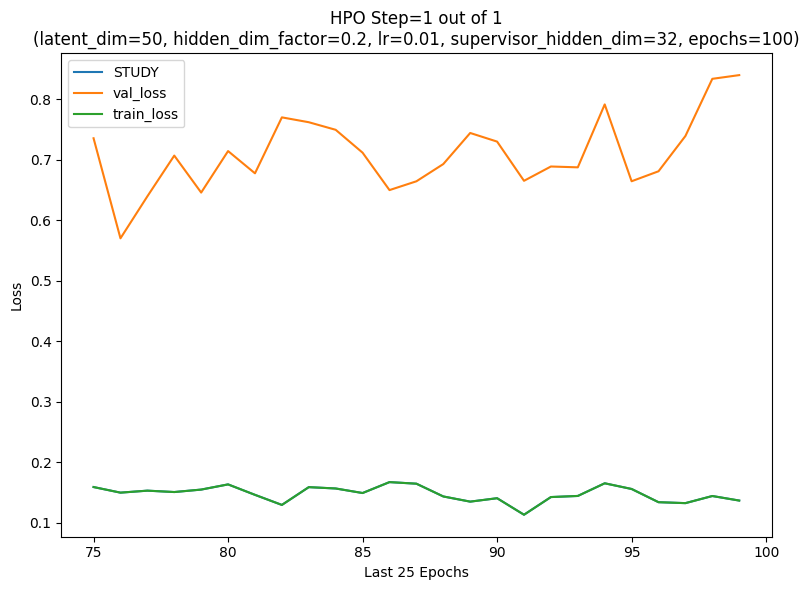

`Trainer.fit` stopped: `max_epochs=100` reached.


,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.761438
1,DirectPred,STUDY,categorical,f1_score,0.790568
2,DirectPred,STUDY,categorical,kappa,0.538358
3,DirectPred,STUDY,categorical,average_auroc,0.868973
4,DirectPred,STUDY,categorical,average_aupr,0.752242


In [21]:
#same as above, but 100 epochs instead of 25
myparams = {'latent_dim': 50, 'hidden_dim_factor': 0.2, 'lr': 0.01, 'supervisor_hidden_dim': 32, 'epochs': 100}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])

trainer.fit(model, train_loader, val_loader)
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

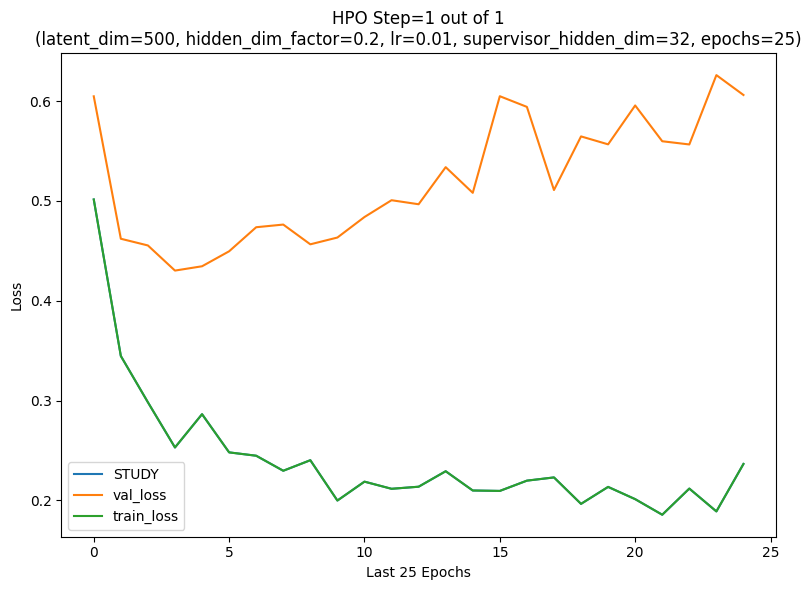

`Trainer.fit` stopped: `max_epochs=25` reached.


,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.794118
1,DirectPred,STUDY,categorical,f1_score,0.804114
2,DirectPred,STUDY,categorical,kappa,0.577664
3,DirectPred,STUDY,categorical,average_auroc,0.858208
4,DirectPred,STUDY,categorical,average_aupr,0.727742


In [22]:
myparams = {'latent_dim': 500, 'hidden_dim_factor': 0.2, 'lr': 0.01, 'supervisor_hidden_dim': 32, 'epochs': 25}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])

trainer.fit(model, train_loader, val_loader)
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

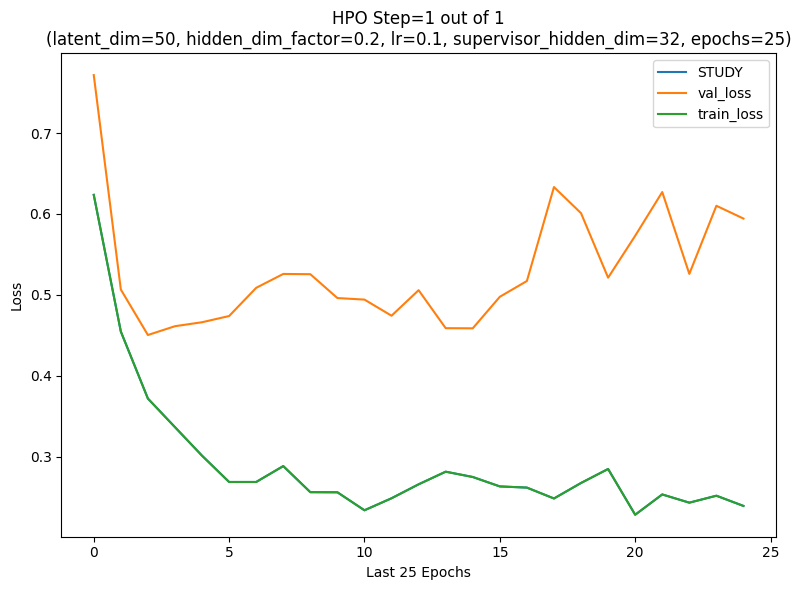

`Trainer.fit` stopped: `max_epochs=25` reached.


,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.726144
1,DirectPred,STUDY,categorical,f1_score,0.762150
2,DirectPred,STUDY,categorical,kappa,0.473324
3,DirectPred,STUDY,categorical,average_auroc,0.838754
4,DirectPred,STUDY,categorical,average_aupr,0.706799


In [23]:
myparams = {'latent_dim': 50, 'hidden_dim_factor': 0.2, 'lr': 0.1, 'supervisor_hidden_dim': 32, 'epochs': 25}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])

trainer.fit(model, train_loader, val_loader)
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

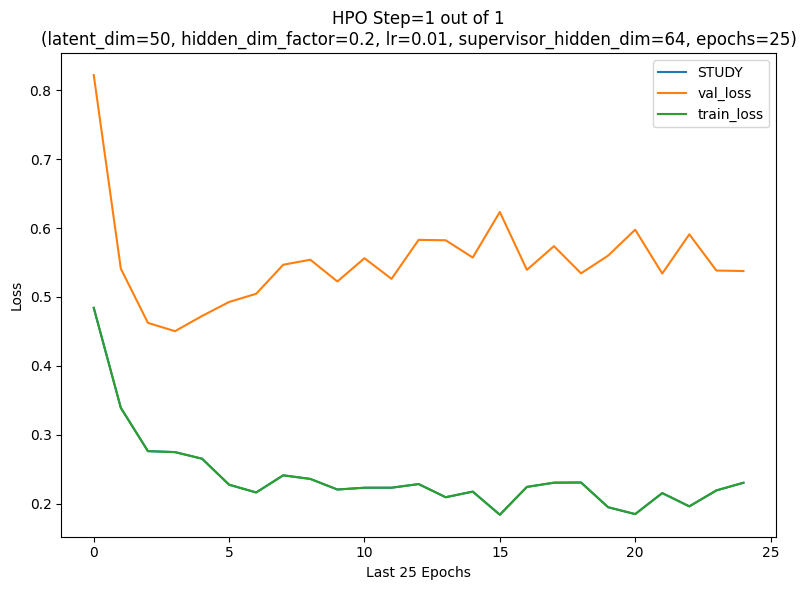

`Trainer.fit` stopped: `max_epochs=25` reached.


,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.760784
1,DirectPred,STUDY,categorical,f1_score,0.760608
2,DirectPred,STUDY,categorical,kappa,0.495652
3,DirectPred,STUDY,categorical,average_auroc,0.827682
4,DirectPred,STUDY,categorical,average_aupr,0.691249


In [24]:
myparams = {'latent_dim': 50, 'hidden_dim_factor': 0.2, 'lr': 0.01, 'supervisor_hidden_dim': 64, 'epochs': 25}
model = flexynesis.DirectPred(config = myparams, dataset = train_dataset, target_variables=['STUDY'])   
trainer = pl.Trainer(max_epochs=myparams['epochs'], default_root_dir="./", logger=False, enable_checkpointing=False, 
                     callbacks=[flexynesis.LiveLossPlot(myparams, 1, 1)])

trainer.fit(model, train_loader, val_loader)
flexynesis.evaluate_wrapper("DirectPred", model.predict(test_dataset), test_dataset)

#### **Warning!!**: In reality, we don't select the best models based on performance on the test dataset.
#### The best model is selected based on the validation loss value, where the model parameters that yields the lowest validation loss is selected to be the best model. 
#### The validation dataset which we use to compute the validation loss is basically a subset of the training dataset. 

## 3. Automating the Hyperparameter Optimisation Procedure

What we did in the above section was to set random hyperparameters, build a model, evaluate the model and try different hyperparameters based on our previous model performance. 
However, this process can be quite time consuming and arbitrary. This process can be automated using a Bayesian approach, where the model training is sequentially done for a number of hyperparameter optimisation iterations. 

Now, we are ready to do a model training using hyperparameter optimisation. 
- `model_class`: We pick `DirectPred` (a fully connected network) for now. 
- `config_name`: We use the default/built-in hyperparameter search space for `DirectPred` class. 
- `target_variables`: 'STUDY' variable contains the type of disease 
- `n_iter`: We do 5 iterations of hyperparameter optimisation. For demonstration purposes, we set it to a small number. 
- `plot_losses`: We want to visualize how the training progresses. 
- `early_stop_patience`: If a training does not show any signs of improving the performance on the `validation` part of the `train_dataset` for at least 10 epochs, we stop the training. This not only significantly decreases the amount spent on training by avoiding unnecessary continuation of unpromising training runs, but also helps avoid over-fitting the network on the training data. 

**Note 1**: Notice how the hyperparameters using in different HPO steps change at each iteration. 

**Note 2**: Also notice that we are running the model for more epochs (500 by default) however, by using "early_stop_patience=10", we avoid lengthy training when validation performance is not improving. 

**Note 3**: Try to follow the the loss curves and the used hyperparameters. See if you can spot which combination yields the lowest/best loss values. 

**Warning!!**: In reality we need to set `n_iter` to higher values so that the optimizer can collect enough data points to learn trends in the parameter space. 

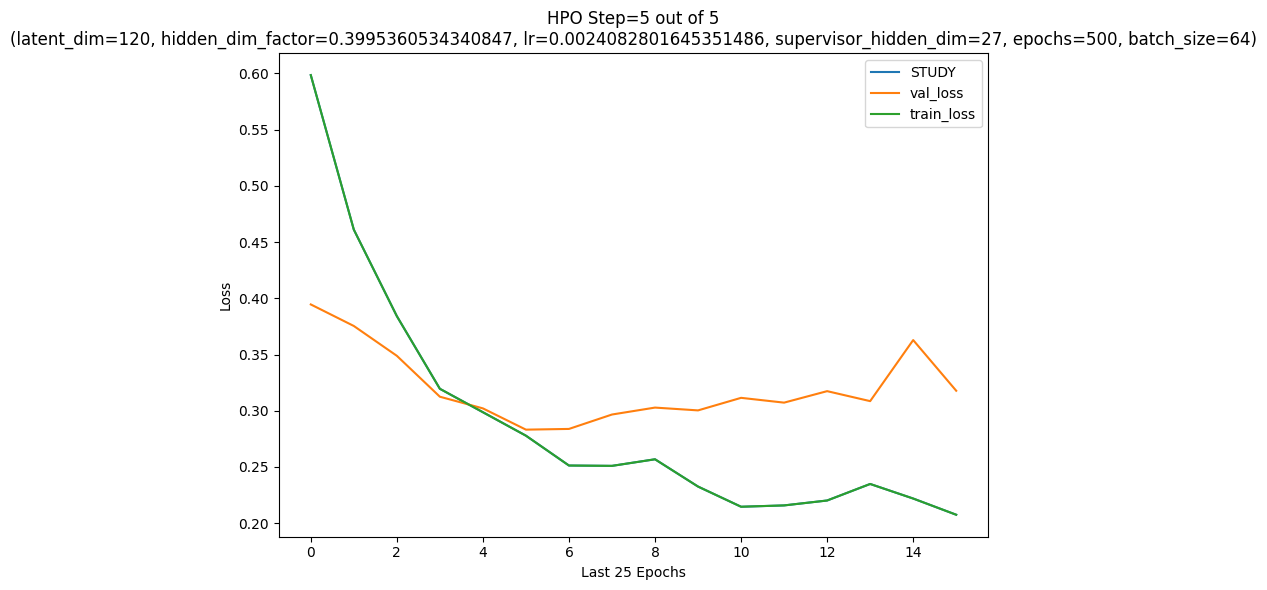

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           STUDY           │     0.317761093378067     │
│         val_loss          │     0.317761093378067     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it, Iteration=5, Best Loss=0.318]

[INFO] current best val loss: 0.317761093378067; best params: {'latent_dim': np.int64(120), 'hidden_dim_factor': 0.3995360534340847, 'lr': 0.0024082801645351486, 'supervisor_hidden_dim': np.int64(27), 'epochs': 500, 'batch_size': np.int64(64)} since 0 hpo iterations


In [25]:
# Define a tuner; See n_iter is the number of 
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        target_variables = ['STUDY'], 
                                        n_iter=5, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
### Perform Training 
model, best_params = tuner.perform_tuning()

In [26]:
## See which hyperparameter combination was the best 
best_params

{'latent_dim': np.int64(120),
 'hidden_dim_factor': 0.3995360534340847,
 'lr': 0.0024082801645351486,
 'supervisor_hidden_dim': np.int64(27),
 'epochs': 15,
 'batch_size': np.int64(64)}

In [27]:
## Evaluate the model and visualising the results
flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model.predict(test_dataset), dataset = test_dataset)                            

,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.778431
1,DirectPred,STUDY,categorical,f1_score,0.801116
2,DirectPred,STUDY,categorical,kappa,0.564238
3,DirectPred,STUDY,categorical,average_auroc,0.856055
4,DirectPred,STUDY,categorical,average_aupr,0.717852


Let's extract the sample embeddings and make a PCA plot and color by the target variable 

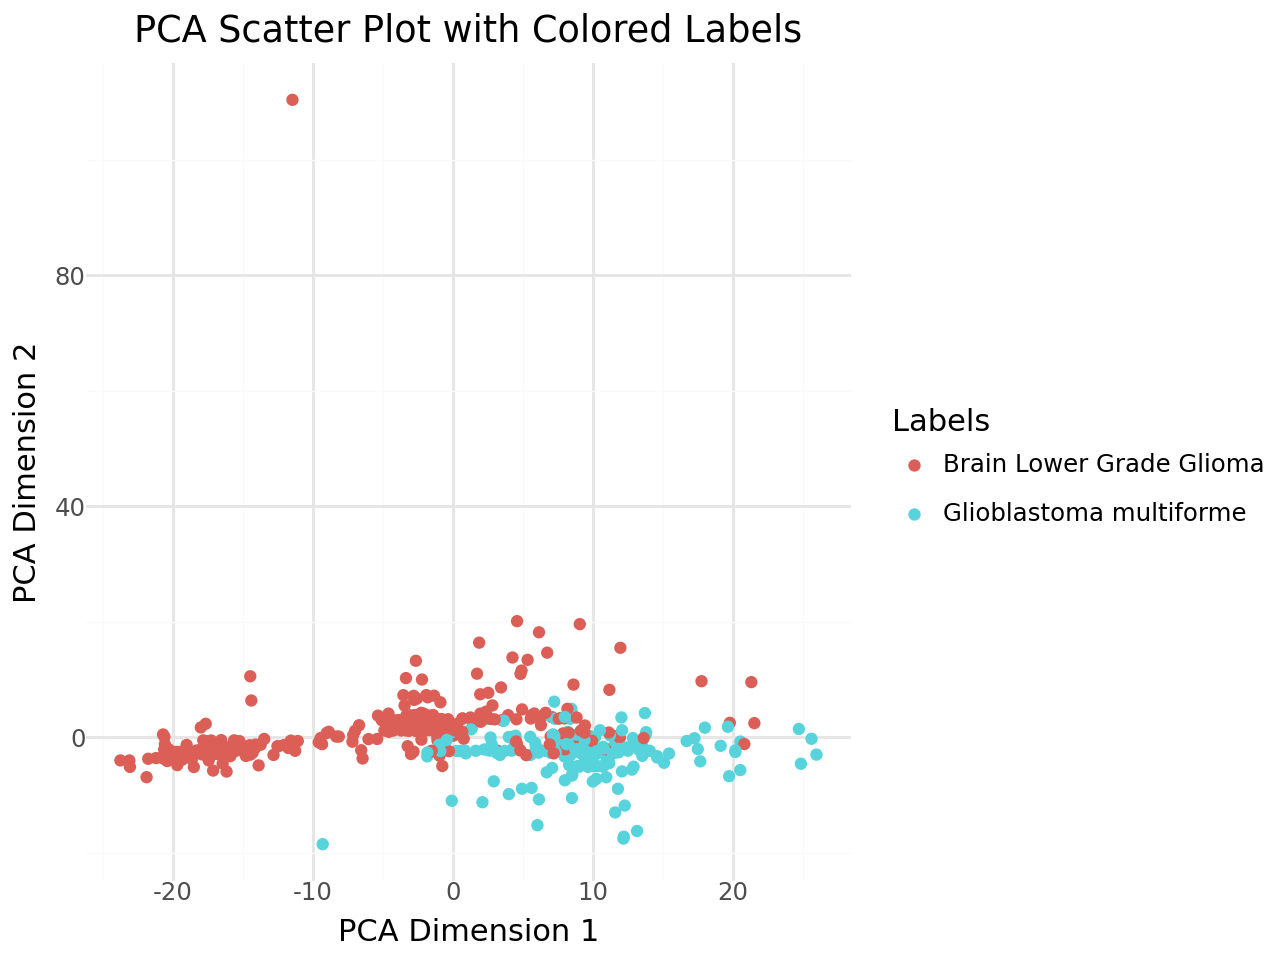

In [28]:
train_embeddings = model.transform(train_dataset)
# labels already set from before, changed to use those instead of study numbers
# labels = [train_dataset.label_mappings["STUDY"][x] for x in train_dataset.ann["STUDY"].numpy()]
flexynesis.plot_dim_reduced(train_embeddings, labels)

Repeat the same for the test dataset: extract sample embeddings for test dataset samples and make a PCA plot, colored by "STUDY" variable 

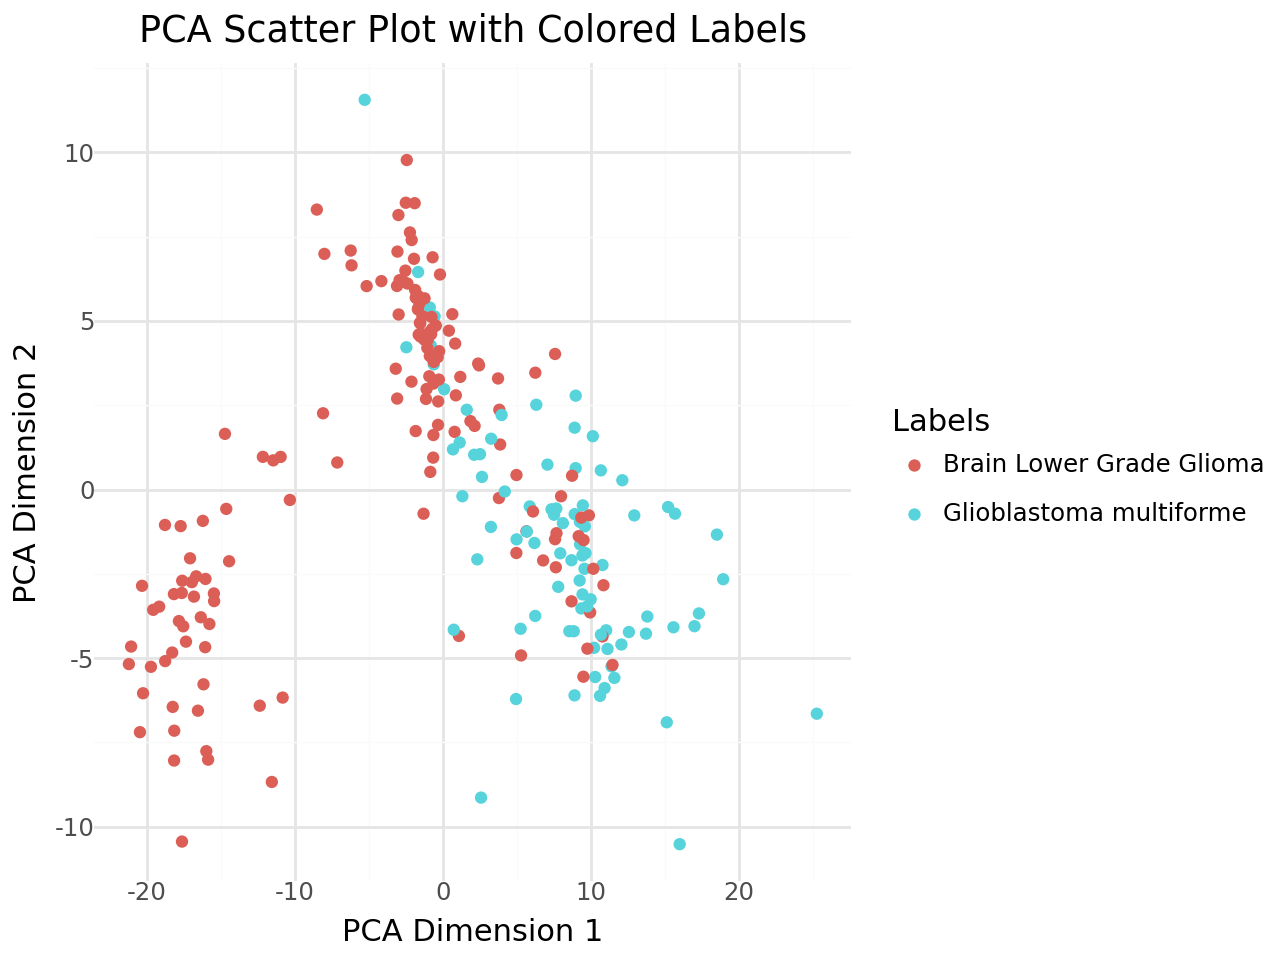

In [29]:
test_embeddings = model.transform(test_dataset)
# set labels in same way as for training set before, changed to use those instead of study numbers
labels = [test_dataset.label_mappings["STUDY"][x] for x in test_dataset.ann["STUDY"].numpy()]
flexynesis.plot_dim_reduced(test_embeddings, labels)

## 3.1 Exercises


**Exercise 1**: 

Look up what Harrell's C-index means and write down a simple description of what it measures. 

- It is a measure of how well a predictive model ranks survival time
- A higher C-index (0-1) means a better prediciton correlation (e.g. an individual with a higher predicted risk score has a lower surivial time than an individual with a lower predicted risk score)



**Exercise 2**:

Now, you build a model using hyperparameter tuning (run at least 10 HPO steps) to predict the survival outcomes of patients. 
Evaluate the final model on test dataset, which computes the "C-index". 

Feel free to cheat from the tutorial available here: https://github.com/BIMSBbioinfo/flexynesis/blob/main/examples/tutorials/survival_subtypes_LGG_GBM.ipynb
See how "OS_STATUS" and "OS_MONTHS" were used. 

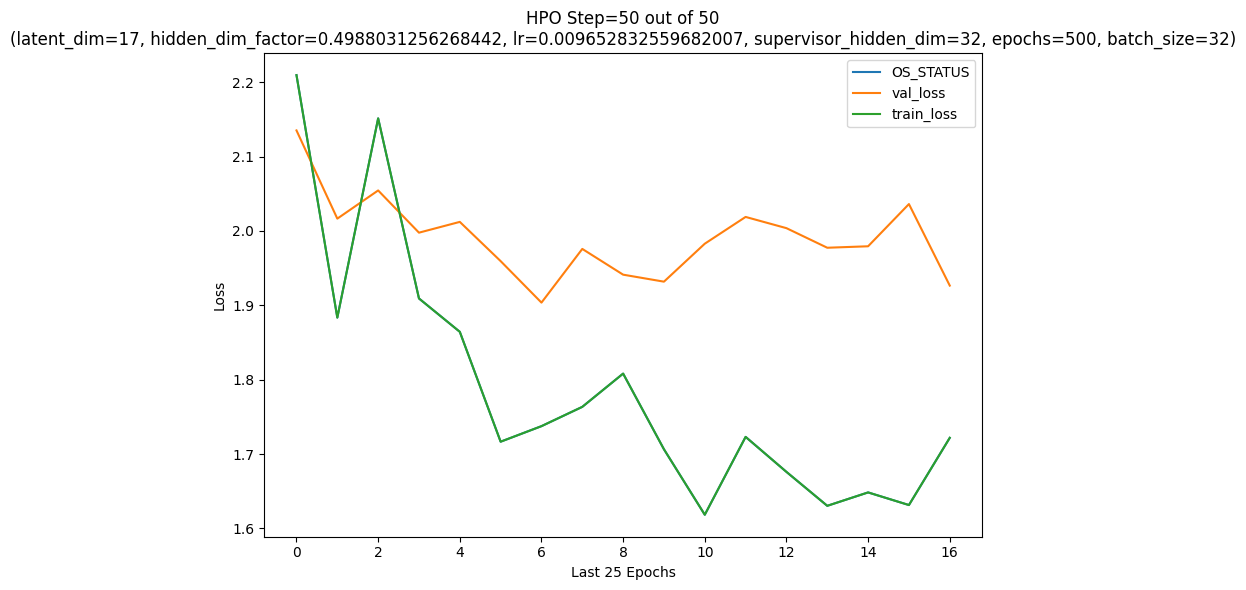

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         OS_STATUS         │     1.926513717533539     │
│         val_loss          │     1.926513717533539     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 50/50 [05:21<00:00,  6.44s/it, Iteration=50, Best Loss=1.65]

[INFO] current best val loss: 1.645938357791385; best params: {'latent_dim': np.int64(128), 'hidden_dim_factor': 0.2, 'lr': 0.01, 'supervisor_hidden_dim': np.int64(32), 'epochs': np.int64(500), 'batch_size': np.int64(32)} since 38 hpo iterations


In [30]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        surv_event_var="OS_STATUS",
                                        surv_time_var="OS_MONTHS",
                                        target_variables = [], 
                                        n_iter=50, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
### Perform Training 
model, best_params = tuner.perform_tuning()

In [31]:
best_params

{'latent_dim': np.int64(128),
 'hidden_dim_factor': 0.2,
 'lr': 0.01,
 'supervisor_hidden_dim': np.int64(32),
 'epochs': 22,
 'batch_size': np.int64(32)}

In [32]:
flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model.predict(test_dataset), dataset = test_dataset, 
                            surv_event_var=model.surv_event_var, surv_time_var=model.surv_time_var)

,method,var,variable_type,metric,value
0,DirectPred,OS_STATUS,numerical,cindex,0.651081


**Exercise 3:**

Again build a model using hyperparameter tuning to predict survival outcomes (as in Exercise 1), however, this time use additional clinical variables as targets. 


    flexynesis.HyperparameterTuning(train_dataset, 
                                    model_class = flexynesis.DirectPred, 
                                    config_name = "DirectPred",
                                    surv_event_var="OS_STATUS",
                                    surv_time_var="OS_MONTHS",
                                    target_variables = [], => What other variables can you use here? Try "AGE" and/or "HISTOLOGICAL_DIAGNOSIS" and see the model performance 
                                    ...
                                    

**See if you can get a better C-index using additional target variables.**

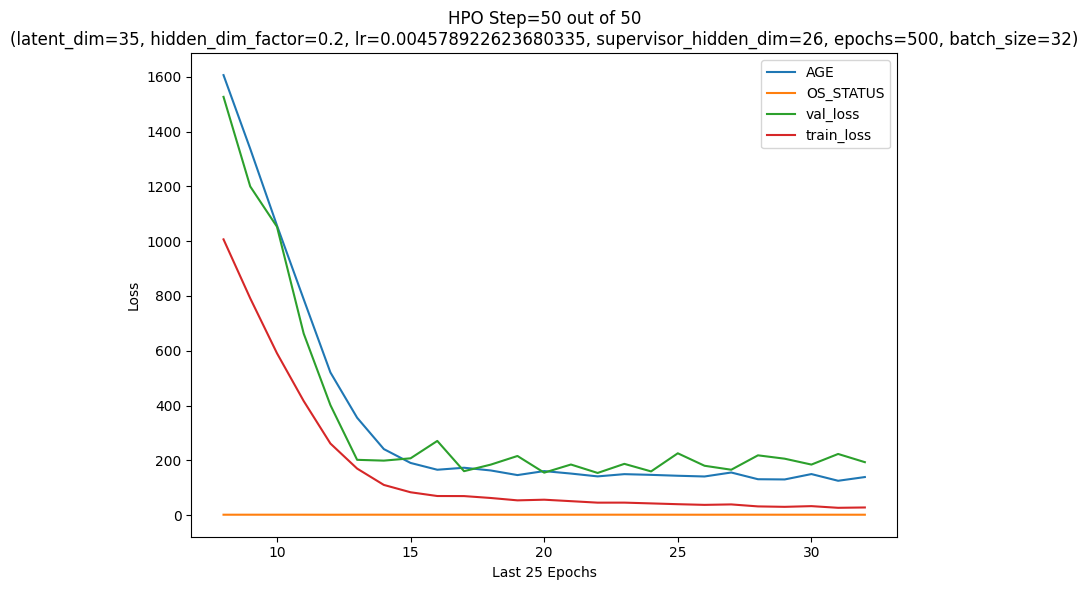

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            AGE            │    191.79644775390625     │
│         OS_STATUS         │     1.866253521395829     │
│         val_loss          │     193.6627062240985     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 50/50 [15:07<00:00, 18.14s/it, Iteration=50, Best Loss=127]

[INFO] current best val loss: 126.68187588817874; best params: {'latent_dim': np.int64(29), 'hidden_dim_factor': 0.2, 'lr': 0.004321745715893343, 'supervisor_hidden_dim': np.int64(30), 'epochs': np.int64(500), 'batch_size': np.int64(64)} since 18 hpo iterations


In [33]:
tuner_w_age = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        surv_event_var="OS_STATUS",
                                        surv_time_var="OS_MONTHS",
                                        target_variables = ["AGE"], 
                                        n_iter=50, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
### Perform Training 
model_w_age, best_params_w_age = tuner_w_age.perform_tuning()

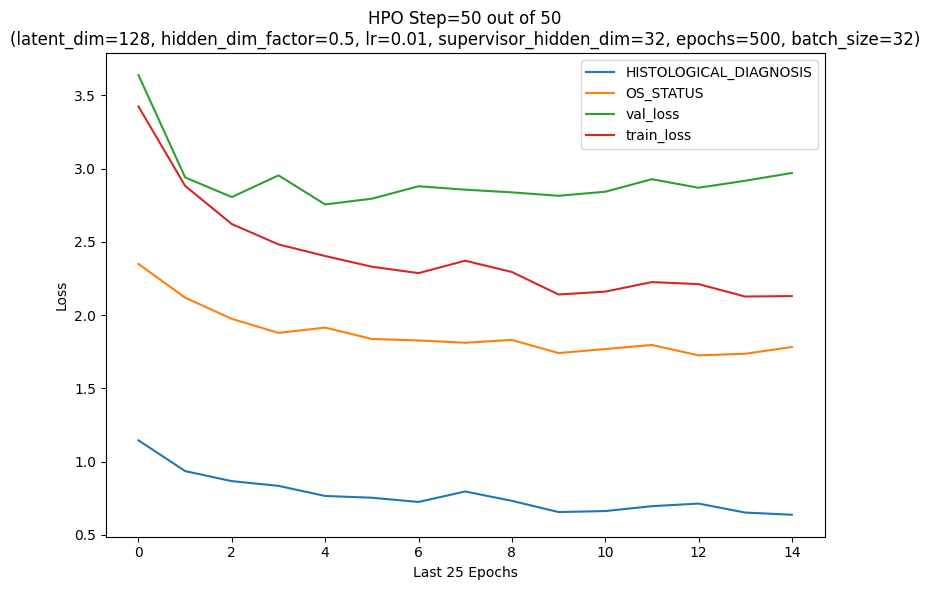

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  HISTOLOGICAL_DIAGNOSIS   │    1.0300884246826172     │
│         OS_STATUS         │      1.9405222978044      │
│         val_loss          │     2.970610682750587     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 50/50 [06:43<00:00,  8.07s/it, Iteration=50, Best Loss=2.58]

[INFO] current best val loss: 2.581982556300703; best params: {'latent_dim': np.int64(128), 'hidden_dim_factor': 0.4285174622762627, 'lr': 0.01, 'supervisor_hidden_dim': np.int64(32), 'epochs': np.int64(500), 'batch_size': np.int64(32)} since 6 hpo iterations


In [34]:
tuner_w_hist = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        surv_event_var="OS_STATUS",
                                        surv_time_var="OS_MONTHS",
                                        target_variables = ["HISTOLOGICAL_DIAGNOSIS"], 
                                        n_iter=50, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
### Perform Training 
model_w_hist, best_params_w_hist = tuner_w_hist.perform_tuning()

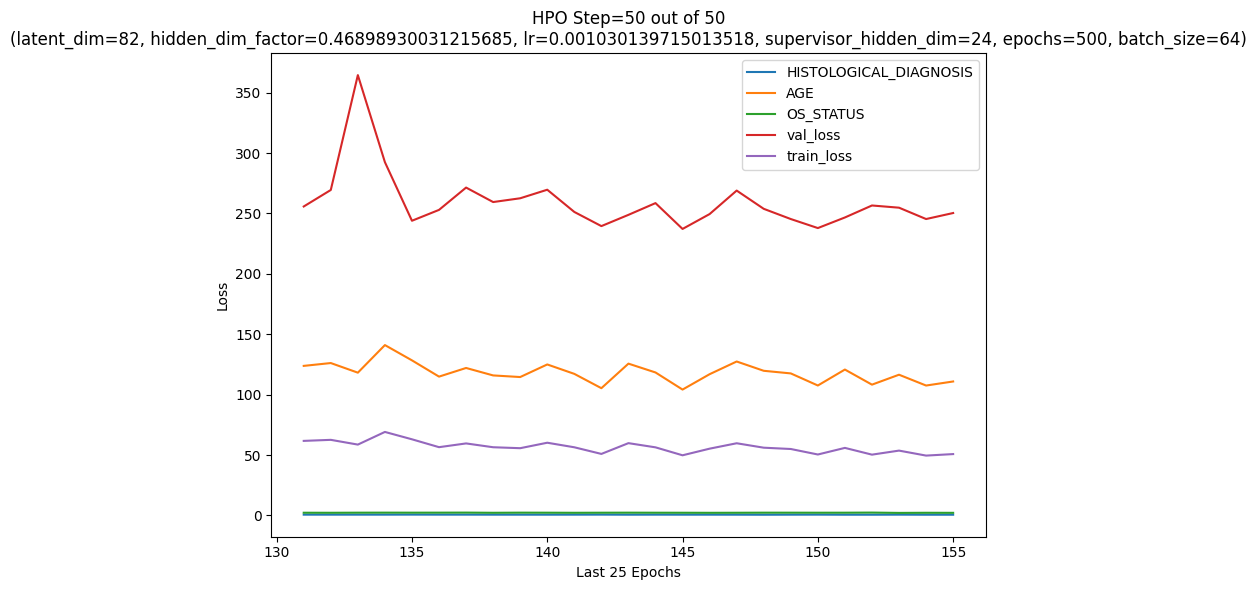

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            AGE            │       247.05078125        │
│  HISTOLOGICAL_DIAGNOSIS   │    0.8093999624252319     │
│         OS_STATUS         │    2.5288828942069146     │
│         val_loss          │     250.3890784321521     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 50/50 [19:29<00:00, 23.39s/it, Iteration=50, Best Loss=154]

[INFO] current best val loss: 154.3650991009179; best params: {'latent_dim': np.int64(16), 'hidden_dim_factor': 0.3372425477346168, 'lr': 0.00984039685969451, 'supervisor_hidden_dim': np.int64(32), 'epochs': np.int64(500), 'batch_size': np.int64(64)} since 27 hpo iterations


In [35]:
tuner_w_hist_age = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        surv_event_var="OS_STATUS",
                                        surv_time_var="OS_MONTHS",
                                        target_variables = ["HISTOLOGICAL_DIAGNOSIS","AGE"], 
                                        n_iter=50, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
### Perform Training 
model_w_hist_age, best_params_w_hist_age = tuner_w_hist_age.perform_tuning()

In [36]:
flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model_w_age.predict(test_dataset), dataset = test_dataset, 
                            surv_event_var=model_w_age.surv_event_var, surv_time_var=model_w_age.surv_time_var)

,method,var,variable_type,metric,value
0,DirectPred,AGE,numerical,mse,208.955933
1,DirectPred,AGE,numerical,r2,0.248464
2,DirectPred,AGE,numerical,pearson_corr,0.498462
3,DirectPred,OS_STATUS,numerical,cindex,0.740837


In [37]:
flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model_w_hist.predict(test_dataset), dataset = test_dataset, 
                            surv_event_var=model_w_hist.surv_event_var, surv_time_var=model_w_hist.surv_time_var)

,method,var,variable_type,metric,value
0,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,balanced_acc,0.472711
1,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,f1_score,0.517903
2,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,kappa,0.347106
3,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,average_auroc,NaN
4,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,average_aupr,NaN
5,DirectPred,OS_STATUS,numerical,cindex,0.697578


In [38]:
flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model_w_hist_age.predict(test_dataset), dataset = test_dataset, 
                            surv_event_var=model_w_hist_age.surv_event_var, surv_time_var=model_w_hist_age.surv_time_var)

,method,var,variable_type,metric,value
0,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,balanced_acc,0.571836
1,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,f1_score,0.612964
2,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,kappa,0.509150
3,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,average_auroc,NaN
4,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,average_aupr,NaN
5,DirectPred,AGE,numerical,mse,212.659653
6,DirectPred,AGE,numerical,r2,0.251911
7,DirectPred,AGE,numerical,pearson_corr,0.501908
8,DirectPred,OS_STATUS,numerical,cindex,0.754306


## 3.2 Survival-risk subtypes 

Use the best model from the above exercises to inspect sample embeddings categorized by survival risk scores. 

Let's group the samples by predicted survival risk scores into 2 groups and visualize the sample embeddings colored by risk subtypes.

**Notice**: You can use the code-below to get survival risk groups, however, notice that you must have built a model with "OS_STATUS" already. 

In [39]:
# get model outputs for survival variable 
# Modle with Histology and Age had the highest C-index
outputs = model_w_hist_age.predict(test_dataset)['OS_STATUS'].flatten() 
risk_scores = np.exp(outputs)
# Define quantile thresholds
quantiles = np.quantile(risk_scores, [0.5])
# Assign groups based on quantiles
groups = np.digitize(risk_scores, quantiles)

In [40]:
# Extract sample embeddings 
E = model.transform(test_dataset)

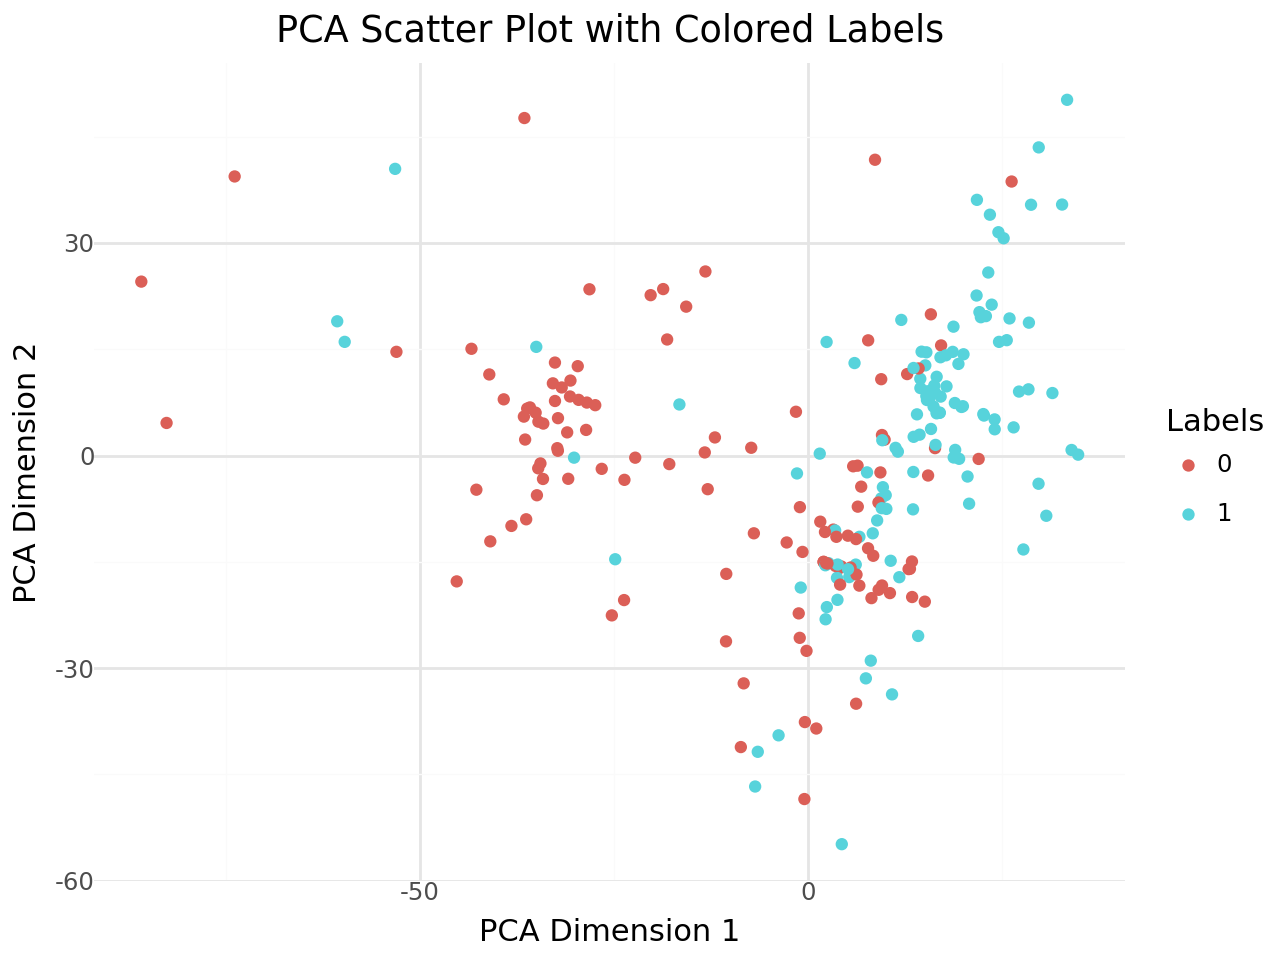

In [41]:
flexynesis.plot_dim_reduced(E, groups)

Let's also see the Kaplan Meier Curves of the risk subtypes

In [42]:
# remove samples with NA values first 
durations = test_dataset.ann['OS_MONTHS']
events = test_dataset.ann['OS_STATUS']
valid_indices = ~torch.isnan(durations) & ~torch.isnan(events)

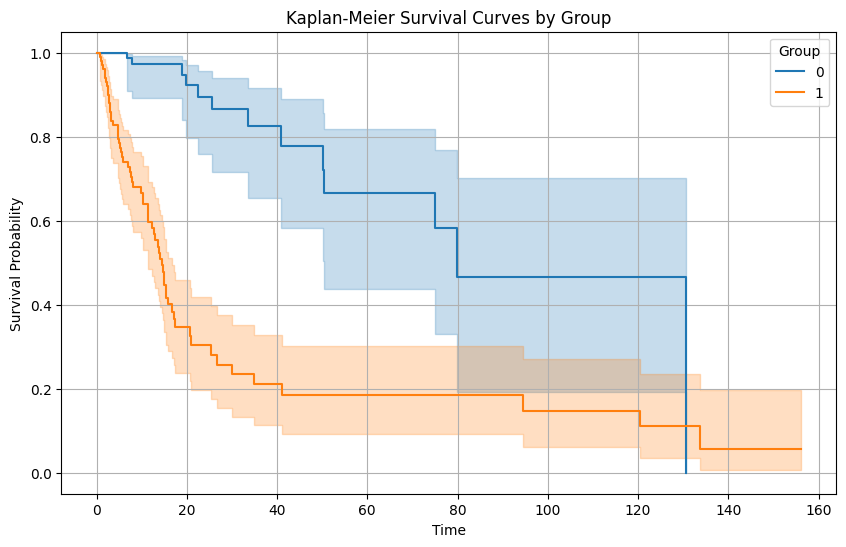

In [43]:
flexynesis.plot_kaplan_meier_curves(durations[valid_indices], events[valid_indices], groups[valid_indices]) 

### Finding survival-associated markers 

We can also compute feature importance scores for prediction of overall survival. 

In [44]:
model_w_hist_age.compute_feature_importance(train_dataset, 'OS_STATUS')

In [45]:
# get top 10 features 
flexynesis.get_important_features(model_w_hist_age, var = 'OS_STATUS', top=10)

,target_variable,target_class,target_class_label,layer,name,importance
0,OS_STATUS,0,,mut,IDH1,0.623612
1,OS_STATUS,0,,mut,ATRX,0.324713
2,OS_STATUS,0,,mut,TP53,0.175178
3,OS_STATUS,0,,mut,IDH2,0.082160
4,OS_STATUS,0,,mut,TEKT4,0.046561
5,OS_STATUS,0,,mut,PIK3CA,0.038255
6,OS_STATUS,0,,mut,COL6A3,0.032404
7,OS_STATUS,0,,mut,MUC16,0.028920
8,OS_STATUS,0,,mut,SVIL,0.026944
9,OS_STATUS,0,,mut,EGFR,0.025502


### Comparing top markers with clinical covariates 

Let's build a linear Cox-PH model including the top 5 markers and other clinical variables such as histological diagnosis, disease type (STUDY), age, and sex. 

In [46]:
# define a data.frame with clinical covariates and top markers along with survival endpoints 
vars = ['AGE', 'SEX', 'HISTOLOGICAL_DIAGNOSIS', 'STUDY', 'OS_MONTHS', 'OS_STATUS']
# read clinical variables 
df_clin = pd.concat(
    [pd.DataFrame({x: train_dataset.ann[x] for x in vars}, index=train_dataset.samples),
     pd.DataFrame({x: test_dataset.ann[x] for x in vars}, index=test_dataset.samples)], 
    axis = 0)
# get top 5 survival markers and extract the input data for these markers for both training and test data
imp = flexynesis.get_important_features(model_w_hist_age, var = 'OS_STATUS', top=5) 
df_imp = pd.concat([train_dataset.get_feature_subset(imp), test_dataset.get_feature_subset(imp)], axis=0)  

# combine markers with clinical variables
df = pd.concat([df_imp, df_clin], axis = 1)
# remove samples without survival endpoints
df = df[df['OS_STATUS'].notna()]
df

,mut_IDH1,mut_ATRX,mut_TP53,mut_IDH2,mut_TEKT4,AGE,SEX,HISTOLOGICAL_DIAGNOSIS,STUDY,OS_MONTHS,OS_STATUS
TCGA-DB-5279,0.982173,-0.585658,-0.809174,-0.148522,-0.09526,59.0,1.0,3.0,0.0,44.5,0.0
TCGA-DU-7011,0.982173,1.707482,1.235829,-0.148522,-0.09526,25.0,1.0,2.0,0.0,105.1,1.0
TCGA-06-5415,-1.018150,-0.585658,-0.809174,-0.148522,-0.09526,60.0,1.0,1.0,1.0,8.5,0.0
TCGA-HT-A616,0.982173,1.707482,-0.809174,-0.148522,-0.09526,36.0,0.0,0.0,0.0,1.8,0.0
TCGA-S9-A6WH,0.982173,-0.585658,-0.809174,-0.148522,-0.09526,73.0,0.0,2.0,0.0,22.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-06-A5U1,-1.018150,-0.585658,-0.809174,-0.148522,-0.09526,78.0,0.0,1.0,1.0,1.9,1.0
TCGA-76-4934,-1.018150,-0.585658,1.235829,-0.148522,-0.09526,66.0,0.0,1.0,1.0,2.5,1.0
TCGA-DB-A4XD,0.982173,1.707482,1.235829,-0.148522,-0.09526,32.0,1.0,0.0,0.0,27.0,0.0
TCGA-DU-5874,0.982173,-0.585658,-0.809174,-0.148522,-0.09526,62.0,0.0,3.0,0.0,15.1,0.0


In [47]:
# build a cox model
coxm = flexynesis.build_cox_model(df, 'OS_MONTHS', 'OS_STATUS')

No low variance features were removed based on event conditioning.


/usr/local/lib/python3.11/site-packages/flexynesis/utils.py:764: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


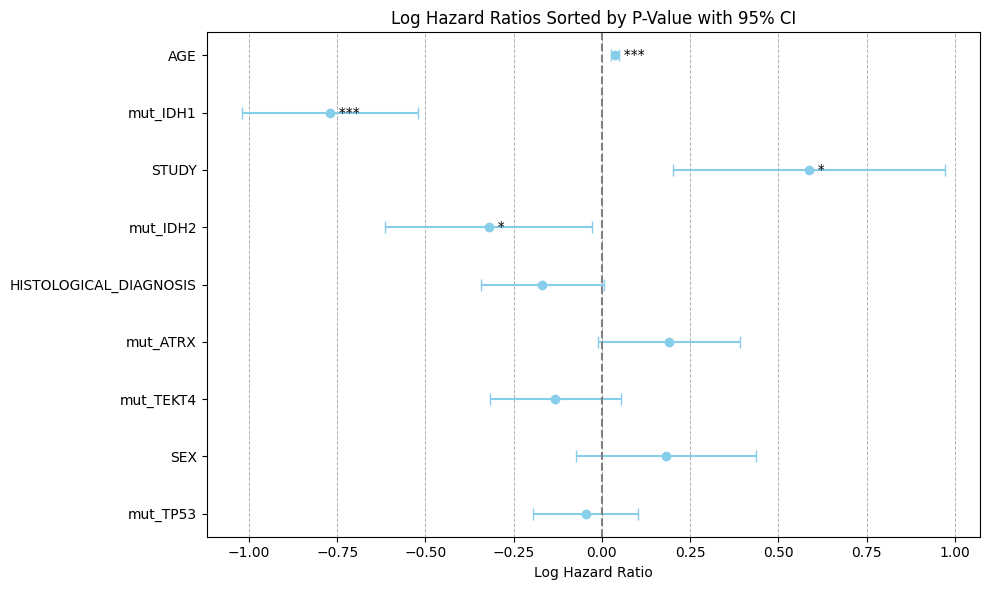

In [48]:
# visualize log-hazard ratios sorted by p-values
flexynesis.plot_hazard_ratios(coxm)

## 3.3 Final Exercise

- Inspect the top 10 markers from section 3.2 and see if they have been characterized in the literature as important markers for Glioma disease progression. 

- Age: Yes, older age is associated with a worse prognosis
- IDH1: Yes, typically mutant IDH1 have a better prognosis
- Study: Yes, the type of Glioma is important
- IDH2: Yes, but less than IDH1
- Histology Diagnosis: Yes, morphology/classification is important
- ATRX: Yes, often co-mutated with IDH (ATRX-deficient IDH-wt are very rare)
- TEKT4: Not widely recognised as playing a role
- Sex: Few studies showing males may have worse outcomes, but not conclusive
- TP53: Possibly, TP53 mutations are common (as they are in many cancers), but little known about role in progression